# Определение перспективного тарифа для телеком-компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов.   
В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<hr>


## Описание тарифов

|        Тариф        | «Смарт» |«Ультра»|
|---------------------|---------|--------|
|  Ежемесячная плата  |   550 р | 1950 р |
|   Минут включено    |   500   |  3000  |
|    SMS включено     |   50 шт | 1000 шт|
|     Гб включено     |   15    |   30   |
|Стоимость сверх минут| 3 р/мин | 1 р/мин|
| Стоимость сверх SMS | 3 р/SMS | 1 р/SMS|
| Стоимость сверх Гб  |  200 р  |  150 р |

<b>Примечание:</b>  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.  

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Описание данных

<b>Для анализа понадобится 5 датасетов:</b>  

- calls.csv - информация о звонках  
- internet.csv - информация об интернет-сессиях  
- messages.csv - информация о сообщениях  
- tariffs.csv - информация о тарифах
- users.csv - информация о пользователях

In [1]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
from scipy.stats import ks_2samp
from scipy.stats import normaltest
import json

import warnings
warnings.simplefilter('ignore')

### calls.csv

Описание данных calls.csv: 

<b>id</b> — уникальный номер звонка  
<b>call_date</b> — дата звонка  
<b>duration</b> — длительность звонка в минутах  
<b>user_id</b> — идентификатор пользователя, сделавшего звонок  

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')

calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<font color='orange'><b>🙊 Наблюдение 3.1</b></font>

1) Длительность в ноль минут и значения с запятыми не бьется с "Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута", но есть объяснение от Яндекс "В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять."   
Скорее всего поменяю тип данных на int  

### internet.csv

Описание данных internet.csv: 

<b>id</b> — уникальный номер сессии  
<b>mb_used</b> — объём потраченного за сессию интернет-трафика (в мегабайтах)  
<b>session_date</b> — дата интернет-сессии  
<b>user_id</b> — идентификатор пользователя  

In [3]:
inet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv', index_col=0)

inet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


<font color='orange'><b>🙊 Наблюдение 3.2</b></font>

~1) Unnamed: 0 я бы переименовала или удалила, так как это по сути внутренний ключ для таблицы~  
2) Значения в mb_used так же не бьются с "«Мегалайн» всегда округляет мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.". Значит, будем окргулять.

###  messages.csv

Описание данных messages.csv: 

<b>id</b> — уникальный номер сообщения  
<b>message_date</b> — дата сообщения  
<b>user_id</b> — идентификатор пользователя, отправившего сообщение  

In [4]:
sms = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')

sms.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


### tariffs.csv

Описание данных tariffs.csv: 

<b>tariff_name</b> — название тарифа  
<b>rub_monthly_fee</b> — ежемесячная абонентская плата в рублях  
<b>minutes_included</b> — количество минут разговора в месяц, включённых в абонентскую плату  
<b>messages_included</b> — количество сообщений в месяц, включённых в абонентскую плату  
<b>mb_per_month_included</b> — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
<b>rub_per_minute</b> — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
<b>rub_per_message</b> — стоимость отправки сообщения сверх тарифного пакета  
<b>rub_per_gb</b> — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

In [5]:
tarif = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

tarif.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


###  users.csv

Описание данных users.csv: 

<b>user_id</b> — уникальный идентификатор пользователя  
<b>first_name</b> — имя пользователя  
<b>last_name</b> — фамилия пользователя  
<b>age</b> — возраст пользователя (годы)  
<b>reg_date</b> — дата подключения тарифа (день, месяц, год)  
<b>churn_date</b> — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
<b>city</b> — город проживания пользователя  
<b>tariff</b> — название тарифного плана   

In [6]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


### Вывод

Изучили поверхностно данные, теперь будем погружаться в их изучение более детально.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Подготовка данных

### Поиск и исправление ошибок, замена типов данных

Поясните, какие ошибки вы нашли и как их исправили.

#### Calls

In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


<font color='orange'><b>🙊 Наблюдение 4.1</b></font>

1) Пропущенных значений нет (это радует)  
2) Изменим тип данных для duration float64 -> int (в большую сторону) и call_date object -> datatime

In [8]:
# изменим тип данных call_date на datatime

calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

# округлим значения в duration вверх

def up_values(i):
    return math.ceil(i)

calls['duration'] = calls['duration'].apply(up_values)  

# check

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [9]:
# так как для будущих расчетов нам необходим месяц, добавим столбец месяца к calls

calls['month'] = pd.DatetimeIndex(calls['call_date']).month

# check

calls.head(3)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6


In [10]:
# Описательная статистика

calls.describe()

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,7.158198,1253.940619,8.574067
std,5.959173,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,2.000000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,11.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


<font color='orange'><b>🙊 Наблюдение 4.2</b></font>

- duration: стандартное отклонение составляет ~ 85% от среднего, что очень много. Посмотрим как это скажеться на анализ.   
- user_id: по данным можно сказать, что таблица отражает данные 500 пользователей.  
- month: в среднем, в августе - сентябре люди совершают больше звонков.

#### Internet

In [11]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


<font color='orange'><b>🙊 Наблюдение 4.3</b></font>

1) Пропущенных значений нет   
2) Изменим тип данных для mb_used float64 -> int (в большую сторону) и session_date object -> datatime  

In [12]:
# переименуем столбец Unnamed: 0

#inet = inet.rename(columns={'Unnamed: 0': 'row_id'})

In [13]:
# изменим тип данных session_date на datatime

inet['session_date'] = pd.to_datetime(inet['session_date'], format = '%Y-%m-%d')

# округлим значения в spent_mb вверх
#inet['mb_used'] = inet['mb_used'].apply(up_values) 

# check

inet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [14]:
# так как для будущих расчетов нам необходим месяц, добавим столбец месяца

inet['month'] = pd.DatetimeIndex(inet['session_date']).month

# check

inet.head(3)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6


In [15]:
# Описательная статистика

inet.describe()

,mb_used,user_id,month
count,149396.000000,149396.000000,149396.000000
mean,370.192426,1252.099842,8.563315
std,278.300951,144.050823,2.788717
min,0.000000,1000.000000,1.000000
25%,138.187500,1130.000000,7.000000
50%,348.015000,1251.000000,9.000000
75%,559.552500,1380.000000,11.000000
max,1724.830000,1499.000000,12.000000


<font color='orange'><b>🙊 Наблюдение 4.4</b></font>

- mb_used: есть значение 0. Возможно, эти данные не будут полезны. Посмотрим дальше как они повлияют на анализ и решим, изменять их или нет.  
- user_id: так же видно, что пользователей 500 человек.  
- mb_used: в среднем 371 мб люди тратят за одну сессию.  
- month: в среднем, в августе - сентябре люди тратят больше трафика.  

#### Messages

In [16]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


<font color='orange'><b>🙊 Наблюдение 4.5</b></font>

1) Пропущенных значений нет  
2) Изменим тип данных для message_date -> datatime  

In [17]:
# изменим тип данных session_date на datatime

sms['message_date'] = pd.to_datetime(sms['message_date'], format = '%Y-%m-%d')

# check

sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [18]:
# так как для будущих расчетов нам необходим месяц, добавим столбец месяца

sms['month'] = pd.DatetimeIndex(sms['message_date']).month

# check

sms.head(3)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8


In [19]:
# Описательная статистика

sms.describe()

,user_id,month
count,123036.000000,123036.000000
mean,1256.989410,8.632262
std,143.523967,2.747328
min,1000.000000,1.000000
25%,1134.000000,7.000000
50%,1271.000000,9.000000
75%,1381.000000,11.000000
max,1499.000000,12.000000


<font color='orange'><b>🙊 Наблюдение 4.6</b></font>
 
- user_id: так же видно, что пользователей 500 человек.   
- month: тенденция сохраняется - в августе - сентябре люди шлют больше смс.  

#### Tariffs

In [20]:
tarif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


<font color='orange'><b>🙊 Наблюдение 4.7</b></font>

1) Пропущенных значений нет  
2) Всего два значения, которые описывают два тарифа.  

#### Users

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


<font color='orange'><b>🙊 Наблюдение 4.8</b></font>

1) Пропущенные значения есть в столбце churn_date. Значит ~92% пользователей на конец 2018 года еще пользовались тарифами компании. Не будем трогать эти данные.   

А так можно было бы заменить NaN на текущий день.

    df_users['churn_date'] = df_users['churn_date'].fillna(value = datetime.datetime.now())
    
2) Изменим тип данных для reg_date и churn_date -> datatime  

In [22]:
# изменим тип данных session_date на datatime

users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

# check

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


<font color='orange'><b>🙊 Наблюдение 4.9</b></font>

Так как людей, которые уже не пользуются тарифом всего 38 ( ~8%), я их удалю, так как нам интересны именно те, кто пользуются.  
В дальнейшем можно эти строки не удалять и проанализировать, пользователи какого тарифа больше отключаются, к примеру.

In [23]:
# создаем новый df

active_users = users.copy()

# меняем пустые значения на 0

active_users.loc[active_users['churn_date'].isna(), 'churn_date'] = 0

# оставляем в df только значения где значения = нулю

active_users = active_users.query('churn_date == 0')

# check

active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     462 non-null    int64         
 1   age         462 non-null    int64         
 2   churn_date  462 non-null    object        
 3   city        462 non-null    object        
 4   first_name  462 non-null    object        
 5   last_name   462 non-null    object        
 6   reg_date    462 non-null    datetime64[ns]
 7   tariff      462 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 32.5+ KB


In [24]:
# изменения для users
# добавим столбец месяца

users['churn_month'] = pd.DatetimeIndex(users['churn_date']).month
users['reg_month'] = pd.DatetimeIndex(users['reg_date']).month

In [25]:
# изучим уникальные значения для churn_date в users

users['churn_month'].unique()

array([nan, 10., 12., 11.,  8.,  9.])

In [26]:
# изменения для active_users
# добавим столбец месяца и удалим стольбцы с путсыми датами (churn_date) и там, где мы вытащили месяц (reg_date)

active_users['reg_month'] = pd.DatetimeIndex(active_users['reg_date']).month
active_users.drop(columns = ['churn_date', "reg_date"],axis = 1, inplace=True)

# check

active_users.head(3)

,user_id,age,city,first_name,last_name,tariff,reg_month
0,1000,52,Краснодар,Рафаил,Верещагин,ultra,5
1,1001,41,Москва,Иван,Ежов,smart,11
2,1002,59,Стерлитамак,Евгений,Абрамович,smart,6


<font color='orange'><b>🙊 Наблюдение 4.10</b></font>

Я подумала, что имена и фамилии можно заменить на пол человека, который поможет проанализировать данные лучше.

Код для разделения имен на женские и мужские <a href="https://ru.stackoverflow.com/questions/1182885/%D0%9A%D0%B0%D0%BA-%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B8%D1%82%D1%8C-%D1%81%D0%BF%D0%B8%D1%81%D0%BE%D0%BA-%D0%B8%D0%BC%D0%B5%D0%BD-%D0%BD%D0%B0-%D0%BC%D1%83%D0%B6%D1%81%D0%BA%D0%B8%D0%B5-%D0%B8-%D0%B6%D0%B5%D0%BD%D1%81%D0%BA%D0%B8%D0%B5">stackoverflow</a>

In [27]:
# def json_to_dict(filename):
#     with open(filename, encoding='utf-8-sig') as f:
#         return json.load(f)

# with open('russian_names.json') as file:
#     stock = json.load(file) 

# def sort(names, all_names, male_names = [], female_names = []):
#     for dicti in all_names:
#         name = dicti['Name']
#         if name in names:
#             if dicti['Sex'] == 'Ж':
#                 female_names.append(name)
#             else:
#                 male_names.append(name)
#     return male_names, female_names

# names = active_users["first_name"].unique()
# filename = 'russian_names.json'
# all_names = json_to_dict(filename)

# sorted_names = sort(names, all_names)

# print(sorted_names[0])
# print(sorted_names[1])

In [28]:
# def name_to_sex(i):
#     if i in sorted_names[0]:
#         return 'Male'
#     else:
#         return 'Female'

# active_users["sex"] = active_users['first_name'].apply(name_to_sex) 

# #check 

# active_users.query('first_name == "Милица"')

In [29]:
# на случай, если файл json не будет доступен -> расскоментировать

def name_to_sex(i):
    if i in ['Авксентий', 'Адам', 'Аким', 'Аксён', 'Алан', 'Александр', 'Алексей', 'Альбин', 'Альфред', 'Анатолий', 'Анвар', 'Андрей', 'Арнольд', 'Арсен', 'Арсений', 'Артемий', 'Артём', 'Афанасий', 'Ахмет', 'Борис', 'Вадим', 'Валерий', 'Варлам', 'Вениамин', 'Виктор', 'Виталий', 'Владимир', 'Владислав', 'Всеволод', 'Гайдар', 'Гарри', 'Гектор', 'Георгий', 'Геральд', 'Герасим', 'Глеб', 'Гордей', 'Григорий', 'Даниил', 'Демьян', 'Денис', 'Евгений', 'Егор', 'Еремей', 'Ермолай', 'Ефим', 'Иван', 'Игорь', 'Илья', 'Иннокентий', 'Исаак', 'Исак', 'Касьян', 'Константин', 'Кузьма', 'Лаврентий', 'Лев', 'Леон', 'Леонид', 'Леонтий', 'Максим', 'Матвей', 'Михаил', 'Мстислав', 'Николай', 'Олег', 'Онисим', 'Павел', 'Пётр', 'Радислав', 'Радомир', 'Рауль', 'Рафаил', 'Рафаэль', 'Рашид', 'Рем', 'Ренальд', 'Ренат', 'Ринат', 'Роберт', 'Ростислав', 'Рубен', 'Рудольф', 'Руслан', 'Рустам', 'Рустем', 'Рэм', 'Святослав', 'Семён', 'Станислав', 'Степан', 'Тимофей', 'Тихон', 'Трифон', 'Трофим', 'Фаддей', 'Фёдор', 'Харитон', 'Эдуард', 'Юлий', 'Юрий', 'Яков', 'Габриель', 'Габриэль', 'Геодар', 'Иулиан', 'Лукий', 'Радим']:
        return 'Male'
    else:
        return 'Female'

active_users["sex"] = active_users['first_name'].apply(name_to_sex) 

#check 

active_users.query('first_name == "Милица"')

,user_id,age,city,first_name,last_name,tariff,reg_month,sex
47,1047,67,Саратов,Милица,Меркулова,smart,10,Female


In [30]:
# check

if active_users.query('sex == "Male"').shape[0] + active_users.query('sex == "Female"').shape[0] == active_users.shape[0]:
    print("OK")
else:
    print('NOK')

OK


In [31]:
# удалим столбцы с именем и фамилией, так как теперь есть пол вместо этого

active_users.drop(columns = ['first_name', "last_name"],axis = 1, inplace=True)

# check

active_users.head(3)

,user_id,age,city,tariff,reg_month,sex
0,1000,52,Краснодар,ultra,5,Male
1,1001,41,Москва,smart,11,Male
2,1002,59,Стерлитамак,smart,6,Male


In [32]:
# Описательная статистика

active_users.describe()

,user_id,age,reg_month
count,462.000000,462.000000,462.000000
mean,1251.166667,46.558442,6.448052
std,144.199414,16.757808,3.395241
min,1000.000000,18.000000,1.000000
25%,1127.500000,32.000000,4.000000
50%,1250.500000,46.000000,6.000000
75%,1376.750000,62.000000,9.000000
max,1499.000000,75.000000,12.000000


<font color='orange'><b>🙊 Наблюдение 4.11</b></font>
 
- средний возраст обладателя тарифа - 47 лет  
- люди в среднем регистрировались в июне

### Вывод

Изучили данные, исправили типы данных и удалили лишние.  
Можно начать их дополнять/ объединять.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Помесячная трата/выручка с каждого пользователя

- Kоличество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя  
- Количество отправленных сообщений по месяцам  
- Объем израсходованного интернет-трафика по месяцам  
- Помесячную выручку с каждого пользователя: вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану

### Потраченные звонки, минуты, смс и Гб помесячно для каждого пользователя

In [33]:
# количество сделанных звонков и потраченных минут по месяцам для каждого пользователя

call_per = calls.groupby(['user_id', 'month'])['duration'].agg(['count', "sum"])

# количество отправленных сообщений по месяцам

sms_per = sms.groupby(['user_id', 'month'])['message_date'].agg(['count'])

# количество потраченных Mб по месяцам

mb_per = inet.groupby(['user_id', 'month'])['mb_used'].agg(['sum'])

In [34]:
# объеденим Series в df

df_pers = pd.concat([call_per, sms_per, mb_per], axis=1)
df_pers = df_pers.reset_index()
df_pers.columns = ['user_id', 'month_count', 'call_amount', 'spent_min', 'sms_amount', 'spent_mb']
df_pers.head()

,user_id,month_count,call_amount,spent_min,sms_amount,spent_mb
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


In [35]:
# с использованием merge

df1 = sms_per.merge(call_per, how='outer', on=['user_id', 'month'])
df2 = df1.merge(mb_per, how='outer', on=['user_id', 'month']).reset_index()
df2.columns = ['user_id', 'month_count', 'sms_amount', 'call_amount', 'spent_min', 'spent_mb']
df2.head()

,user_id,month_count,sms_amount,call_amount,spent_min,spent_mb
0,1000,5,22.0,22.0,159.0,2253.49
1,1000,6,60.0,43.0,172.0,23233.77
2,1000,7,75.0,47.0,340.0,14003.64
3,1000,8,81.0,52.0,408.0,14055.93
4,1000,9,57.0,58.0,466.0,14568.91


In [36]:
# check

if df_pers.shape[0] == df2.shape[0]:
    print("Таблицы совпадают")
else:
    print("Что-то пошло не так")

Таблицы совпадают


<hr>


In [37]:
# переведем Мб в Гб, добавим новый столбец

def to_gb(row):
    if row == 0:
        return 0
    elif row != 0:
        result = row / 1024
        return result

df_pers['spent_gb'] = df_pers['spent_mb'].apply(to_gb) 

#check

df_pers.tail(3)

,user_id,month_count,call_amount,spent_min,sms_amount,spent_mb,spent_gb
3211,1499,10,68.0,449.0,48.0,17788.51,17.371592
3212,1499,11,74.0,612.0,59.0,17963.31,17.542295
3213,1499,12,69.0,492.0,66.0,13055.58,12.749590


In [38]:
# объединям колонки с active_users и создаем новый df

df = active_users.merge(df_pers, how='inner', on='user_id')
df.head()

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_mb,spent_gb
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,2253.49,2.200674
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23233.77,22.689229
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14003.64,13.675430
3,1000,52,Краснодар,ultra,5,Male,8,52.0,408.0,81.0,14055.93,13.726494
4,1000,52,Краснодар,ultra,5,Male,9,58.0,466.0,57.0,14568.91,14.227451


In [39]:
# добавим столбец с тарифом

def tariff_plan(row):
    if row['tariff'] == 'smart':
        result = tarif['rub_monthly_fee'].values[0]
        return result
    else:
        result = tarif['rub_monthly_fee'].values[1]
        return result

df['month_pay'] = df.apply(tariff_plan, axis=1) 

In [40]:
# посмотрим, есть ли пустые значения в новом df

df.isna().sum()

user_id          0
age              0
city             0
tariff           0
reg_month        0
sex              0
month_count      0
call_amount     40
spent_min       40
sms_amount     450
spent_mb        10
spent_gb        10
month_pay        0
dtype: int64

<font color='orange'><b>🙊 Наблюдение 5.0</b></font>
 
Посмотрим, что можно сделать с call_amount, spent_min, sms_amount и spent_mb/gb нужно исправить.

In [41]:
# посмотрим на строки с путыми значениями в call_amount

df[df['call_amount'].isna()].head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_mb,spent_gb,month_pay
497,1091,36,Набережные Челны,ultra,5,Female,5,NaN,NaN,30.0,10703.37,10.452510,1950
498,1091,36,Набережные Челны,ultra,5,Female,6,NaN,NaN,30.0,10236.19,9.996279,1950
499,1091,36,Набережные Челны,ultra,5,Female,7,NaN,NaN,35.0,16444.98,16.059551,1950


In [42]:
# посмотрим на строки с путыми значениями в sms_amount

df[df['sms_amount'].isna()].head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_mb,spent_gb,month_pay
8,1001,41,Москва,smart,11,Male,11,59.0,430.0,NaN,18429.34,17.997402,550
9,1001,41,Москва,smart,11,Male,12,63.0,414.0,NaN,14036.66,13.707676,550
42,1006,21,Ульяновск,smart,2,Male,2,3.0,42.0,NaN,1392.15,1.359521,550


<font color='orange'><b>🙊 Наблюдение 5.1</b></font>
 
Видим, что там где пустые звонки или смс например, остальные значения не пустые и количество Гб, например, превышает бесплатное количество в тарифе 'smart' (лимит 15 Гб).  

In [43]:
# Проверим, есть ли строки, где все данные пустые

df[(df['call_amount'].isnull()) & (df['sms_amount'].isnull()) & (df['spent_mb'].isnull())].shape[0]

0

<font color='orange'><b>🙊 Наблюдение 5.2</b></font>
 
Значит, могу предположить, что данные пустые, потому что человек в этом месяцу не пользовался этими услугами.  
Значит, заменю все NaN на 0  

In [44]:
list_columns = ['call_amount','spent_min','sms_amount','spent_mb', 'spent_gb']

for column in list_columns:
    df[column] = df[column].fillna(0)

# check

df.isna().sum()

user_id        0
age            0
city           0
tariff         0
reg_month      0
sex            0
month_count    0
call_amount    0
spent_min      0
sms_amount     0
spent_mb       0
spent_gb       0
month_pay      0
dtype: int64

In [45]:
# округлим значения в spent_gb вверх и удалим столбец spent_mb

df['spent_gb'] = df['spent_mb'].apply(to_gb) 
df['spent_gb'] = df['spent_gb'].apply(up_values) 
df.drop(columns = ['spent_mb'],axis = 1, inplace=True)

# check

df.head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,3,1950
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23,1950
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14,1950


### Помесячная выручка с каждого пользователя

In [46]:
# вспомним, как выглядит таблица с данными по тарифам

tarif.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [47]:
# рассчитаем помесячную выручку с каждого пользователя

# функция для расчета использования минут больше лимита

def calls_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['spent_min'] - tarif['minutes_included'].values[0]
        return result
    else:
        result = row['spent_min'] - tarif['minutes_included'].values[1]
        return result

# функция для расчета использования смс больше лимита

def sms_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['sms_amount'] - tarif['messages_included'].values[0]
        return result
    else:
        result = row['sms_amount'] - tarif['messages_included'].values[1]
        return result    
    
# функция для расчета использования Гб больше лимита

def gb_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['spent_gb'] - int((tarif['mb_per_month_included'].values[0])/1000)
        return result
    else:
        result = row['spent_gb'] - int((tarif['mb_per_month_included'].values[1])/1000)
        return result   

In [48]:
# применим функции

df['min_over'] = df.apply(calls_over_plan, axis=1)
df['sms_over'] = df.apply(sms_over_plan, axis=1)
df['gb_over'] = df.apply(gb_over_plan, axis=1)

# check

df.head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay,min_over,sms_over,gb_over
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,3,1950,-2841.0,-978.0,-27
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23,1950,-2828.0,-940.0,-7
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14,1950,-2660.0,-925.0,-16


In [49]:
# исправим с помощью функции все значения, которые меньше нуля - они показывают, что лимит не превышался

def correction(row):
    if row < 0:
        row = 0
        return row
    else:
        return row

# применим функцию    

df['min_over'] = df['min_over'].apply(correction)
df['sms_over'] = df['sms_over'].apply(correction)
df['gb_over'] = df['gb_over'].apply(correction)

# check

df.head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay,min_over,sms_over,gb_over
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,3,1950,0.0,0.0,0
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23,1950,0.0,0.0,0
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14,1950,0.0,0.0,0


In [50]:
# остаток умножаем на значение из тарифного плана

# минуты

def calls_prof(row):
    if row['tariff'] == 'smart':
        result = row['min_over'] * tarif['rub_per_minute'].values[0]
        return result
    else:
        result = row['min_over'] * tarif['rub_per_minute'].values[1]
        return result

# смс

def sms_prof(row):
    if row['tariff'] == 'smart':
        result = row['sms_over'] * tarif['rub_per_message'].values[0]
        return result
    else:
        result = row['sms_over'] * tarif['rub_per_message'].values[1]
        return result    
    
# Гб

def gb_prof(row):
    if row['tariff'] == 'smart':
        result = row['gb_over'] * tarif['rub_per_gb'].values[0]
        return result
    else:
        result = row['gb_over'] * tarif['rub_per_gb'].values[1]
        return result  

In [51]:
# применим функцию    

df['add_pay_min'] = df.apply(calls_prof, axis=1)
df['add_pay_sms'] = df.apply(sms_prof, axis=1)
df['add_pay_gb'] = df.apply(gb_prof, axis=1)

# check

df.head(3)

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay,min_over,sms_over,gb_over,add_pay_min,add_pay_sms,add_pay_gb
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,3,1950,0.0,0.0,0,0.0,0.0,0
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23,1950,0.0,0.0,0,0.0,0.0,0
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14,1950,0.0,0.0,0,0.0,0.0,0


In [52]:
# итого общая сумма помесячно в каждом тарифе для отдельного пользователя

df['profit'] = df['add_pay_min'] + df['add_pay_sms'] + df['add_pay_gb'] + df["month_pay"]

# удалим столбцы add_pay_min, add_pay_sms, add_pay_gb

df.drop(columns = ['add_pay_min', 'add_pay_sms', 'add_pay_gb'],axis = 1, inplace=True)

#check 

df.head()

,user_id,age,city,tariff,reg_month,sex,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay,min_over,sms_over,gb_over,profit
0,1000,52,Краснодар,ultra,5,Male,5,22.0,159.0,22.0,3,1950,0.0,0.0,0,1950.0
1,1000,52,Краснодар,ultra,5,Male,6,43.0,172.0,60.0,23,1950,0.0,0.0,0,1950.0
2,1000,52,Краснодар,ultra,5,Male,7,47.0,340.0,75.0,14,1950,0.0,0.0,0,1950.0
3,1000,52,Краснодар,ultra,5,Male,8,52.0,408.0,81.0,14,1950,0.0,0.0,0,1950.0
4,1000,52,Краснодар,ultra,5,Male,9,58.0,466.0,57.0,15,1950,0.0,0.0,0,1950.0


In [53]:
# проверим на дубликаты новый df

print(f'Количество дубликатов {df.duplicated().sum()}')

Количество дубликатов 0


In [54]:
# проверим тип данных в новом df

df.dtypes        

user_id          int64
age              int64
city            object
tariff          object
reg_month        int64
sex             object
month_count      int64
call_amount    float64
spent_min      float64
sms_amount     float64
spent_gb         int64
month_pay        int64
min_over       float64
sms_over       float64
gb_over          int64
profit         float64
dtype: object

In [55]:
# изменим тип данных на int, так как все значения в изменяемых столбцах целочисленные

list_columns = ['call_amount', 'spent_min', 'sms_amount', 'spent_gb', 'min_over', 'sms_over', 'gb_over', 'profit']

for column in list_columns:
    df[column] = df[column].astype('int')   

In [56]:
# посмотрим, как изменились данные

df.describe(include=[object])

,city,tariff,sex
count,3027,3027,3027
unique,76,2,2
top,Москва,smart,Female
freq,570,2118,1619


<font color='orange'><b>🙊 Наблюдение 5.3</b></font>
 
- Чаще всего тарифом пользуются москвичи (~19% от всех пользователей)   
- Популярный тариф - smart (~ 72% пользователей выбирают его)  
- Ползуются данной сетью мужчины и женщины почти в одинаковой степени (М 46%/ Ж 54%).

In [57]:
# посмотрим, как изменились данные

df.describe(include=[int])

,user_id,age,reg_month,month_count,call_amount,spent_min,sms_amount,spent_gb,month_pay,min_over,sms_over,gb_over,profit
count,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.00000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000
mean,1253.568219,46.527915,4.692435,8.346217,63.656426,455.553353,38.882392,17.35745,970.416254,30.356789,4.156921,2.338619,1529.969937
std,144.017916,16.645684,2.900228,2.910948,33.357894,242.690614,36.503511,7.31713,641.848134,74.819507,11.688828,3.520684,798.322912
min,1000.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,550.000000,0.000000,0.000000,0.000000,550.000000
25%,1130.000000,32.000000,2.000000,6.000000,41.000000,287.000000,10.000000,13.00000,550.000000,0.000000,0.000000,0.000000,750.000000
50%,1256.000000,46.000000,4.000000,9.000000,63.000000,449.000000,30.000000,17.00000,550.000000,0.000000,0.000000,0.000000,1631.000000
75%,1380.500000,62.000000,7.000000,11.000000,83.000000,597.000000,58.000000,21.00000,1950.000000,0.000000,0.000000,4.000000,1950.000000
max,1499.000000,75.000000,12.000000,12.000000,244.000000,1673.000000,224.000000,49.00000,1950.000000,935.000000,93.000000,23.000000,6770.000000


<font color='orange'><b>🙊 Наблюдение 5.4</b></font>
 
- user_id: Пользователей так же 500 человек  
- age: Средний возраст ~ 47 лет остался прежним  
- reg_month: А вот месяц регистрации для этой выборки сдвинулся на более ранний срок: с июня на апрель  
- month_count: Выборка по подсчету для количества звонков, смс и тд всключает в себя все месяцы года
- call_amount: в среднем в месяц люди звонят ~64 раза  
- spent_min: в среднем в месяц людям хватает ~456 мин для всех звонков в сумме  
- sms_amount: в среднем людям хватает ~39 смсок на месяц  
- spent_gb: в среднем люди используют ~17 Гб в месяц  
- month_pay: 50% людей используют smart тариф  
- min_over: больше чем 75% людей хватает включенных в тариф минут  
- sms_over: больше чем 75% людей хватает включенных в тариф sms  
- gb_over: 50% людей используют включенные в тариф ГБ, избегая сверхпереплаты  
- profit: в среднем компания получает в месяц 1500 с пользователя

### Вывод

Можно предположить по данным, что раз большиснтво людей используют smart, но в месяц компания в среднем получает больше,чем 550 руб с человека, то люди явно используют тарифы сверхлимита. И могу предположить, что это происходт, в основном, из-за нехватки Гб в тарифах.

Дальше будем использовать таблицу df для анализа.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [58]:
# разделим df на две таблицы по тарифу

ultra_df = df.query("tariff == 'ultra'")
smart_df = df.query("tariff == 'smart'")

### Распределение количества людей по тарифам

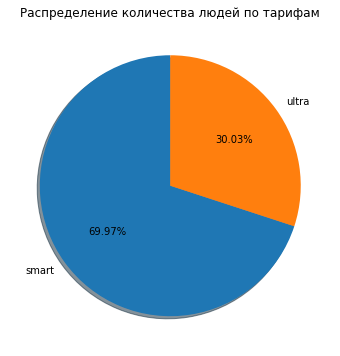

In [59]:
# cтроим круговую диаграмму для распределения количества людей по тарифам

count_people = df["tariff"].value_counts()
fig = plt.figure(figsize =(6, 6))
labels = "smart", "ultra"
plt.pie(count_people, labels=labels, autopct='%1.2f%%',shadow=True, startangle=90)
plt.title("Распределение количества людей по тарифам")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.1</b></font>
 
Визуализировали прдидущий вывод о распределении людей по тарифам

### Распределение пола по тарифам

In [60]:
# распределение пола по тарифам

sex_per_ultra = ultra_df.groupby(['sex'])['sex'].agg(['count'])
sex_per_smart = smart_df.groupby(['sex'])['sex'].agg(['count'])

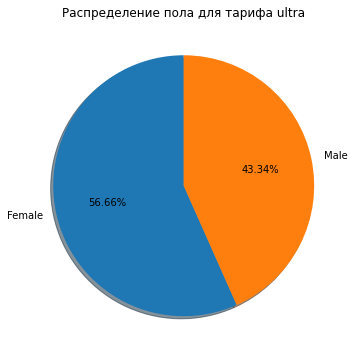

In [61]:
ultra_people = ultra_df['sex']
ultra_people = ultra_people.value_counts()

sex = ["Female", "Male"]
fig = plt.figure(figsize =(6, 6))
plt.pie(ultra_people, labels=sex, autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Распределение пола для тарифа ultra")
plt.show()

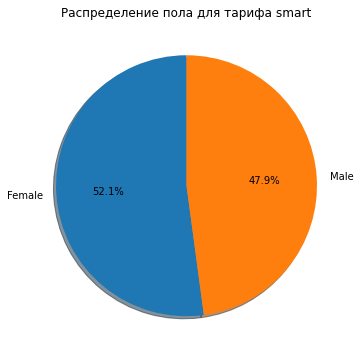

In [62]:
smart_people = smart_df['sex']
smart_people = smart_people.value_counts()

sex = ["Female", "Male"]
fig = plt.figure(figsize =(6, 6))
plt.pie(smart_people, labels=sex, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Распределение пола для тарифа smart")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.2</b></font>
 
Видим, что более популярный тариф у мужчин - smart, у женщин - ultra.  
Думаю тут дело в практичности и виду деятельности человека - тем, кто любит поболтать и посидеть в интаграмчике - нужен ultra; тем, кто считает, что "краткость - сестра таланта" - smart

### Распределение возраста по тарифам

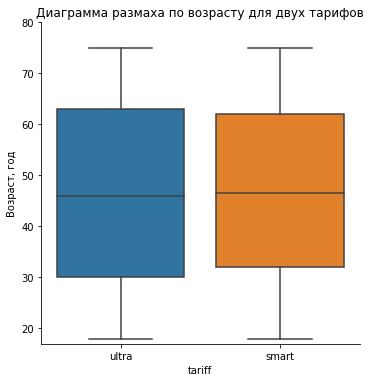

In [63]:
sns.catplot(x='tariff', y="age", kind="box", data=df)
plt.ylim(17, 80)
plt.ylabel('Возраст, год')
plt.title("Диаграмма размаха по возрасту для двух тарифов")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.3</b></font>
 
Усы для двух графиков одинаковы, потому что (по моему мнению), это связано с законностью оформления документов в компании (с 18 лет и тд.). В целом, вариации возраста smart пользователей уже, чем в ultra. Что говорит о том, что smart предпочитают именно в какой-то определнный период жизни. Медиана больше у smarta, а значит, возраст для тарифа smart чуть выше, чем для ultra.

### Общее количество минут разговора, количества сообщений и  объёма интернет-трафика для тарифов в месяц

In [64]:
# сгруппируем

df_sum = df.groupby(['tariff', 'month_count'])['spent_min', "sms_amount", "spent_gb", 'profit'].agg(["sum"])
df_sum = df_sum.reset_index()
df_sum.columns = ['tariff', 'month', 'min_per_month', 'sms_per_month', 'gb_per_month', 'profit_per_month']
df_sum

,tariff,month,min_per_month,sms_per_month,gb_per_month,profit_per_month
0,smart,1,6737,604,281,23775
1,smart,2,16474,1370,650,46351
2,smart,3,28590,2341,1093,84120
3,smart,4,38916,3272,1424,100615
4,smart,5,51658,4523,2106,158015
5,smart,6,61967,5234,2472,187186
6,smart,7,78213,6365,2977,228792
7,smart,8,94202,7456,3694,290193
8,smart,9,106181,8256,4034,309496
9,smart,10,121083,9444,4744,384877


### Mean, std, var

In [65]:
df_var = df.groupby(['tariff'])['spent_min', "sms_amount", "spent_gb", 'profit'].agg(['mean', 'var', 'std'])
df_var = df_var.reset_index()
df_var.columns = ['tariff', 'mean_min', 'var_min', 'std_min', 'mean_sms', 'var_sms', 'std_sms', 'mean_gb', 'var_gb', 'std_gb', 'mean_profit', 'var_profit', 'std_profit']
df_var

,tariff,mean_min,var_min,std_min,mean_sms,var_sms,std_sms,mean_gb,var_gb,std_gb,mean_profit,var_profit,std_profit
0,smart,422.773843,36558.949774,191.203948,33.587819,808.838529,28.440087,16.390463,32.651907,5.714185,1299.489613,675623.341177,821.963102
1,ultra,531.930693,102702.467658,320.472257,51.218922,2337.157968,48.344162,19.610561,95.037598,9.748723,2066.996700,136090.199328,368.904052


<font color='orange'><b>🙊 Наблюдение 6.4</b></font>
 
Минуты:  
* среднее количество потраченных минут больше в тарифе ultra  
* величина стандартного отклонения говорит о том, что пользователи smart тарифа чаще превышают бесплатынй лимит (500 мин) почти в два раза согласно std*3 - mean_min + 3*std_min.  
* 3 sigma для ultra не превышает 1500 мин, лимит 3000 мин.

СМС:  
* среднее количество потраченных смс опять больше в траифе smart  
* по стандартному отклонению можно скзаать, что пользователем smart тарифа так же не хватает количества бесплатных смс, чего не скажешь про пользователей ultra  

Гб:  
* среднее количество потраченных Гб снова больше в траифе smart, хотя отличается всего на 16%  
* в этот раз 3 sigma правило показывает, что 30 Гб не хватает для пользователей ultra тарифа: 20 + 3 * 10 = 50 Гб (лимит 30 Гб), smart правда тоже не отстает: 16.4 + 18 ~ 34 Гб, что в два раза превышает лимит. 

### Гистрограммы Smart тарифа

In [66]:
# разделим df на две таблицы по тарифу

df_ultra = df.query("tariff == 'ultra'")
df_smart = df.query("tariff == 'smart'")

In [67]:
# посмотрим на статистику по spent_min

df_smart['spent_min'].describe()

count    2118.000000
mean      422.773843
std       191.203948
min         0.000000
25%       287.250000
50%       430.000000
75%       550.000000
max      1435.000000
Name: spent_min, dtype: float64

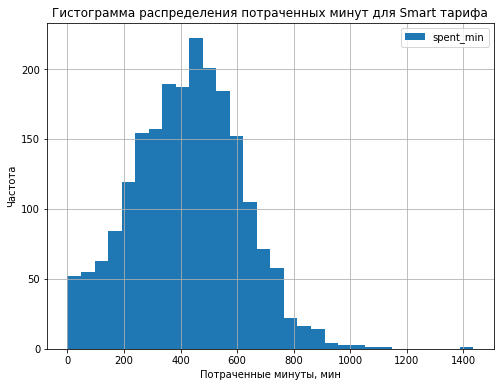

In [68]:
# строим гистрограмму

df_smart.plot(y = 'spent_min', kind = 'hist', bins = 30, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных минут для Smart тарифа")
plt.xlabel("Потраченные минуты, мин")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.5</b></font>
 
Распределение похоже на нормальное. Медиана (== пик) - 430 мин, лимит тарифа - 500 мин. Это означает, что многие превышают лимит (до 800 мин). Есть и больше 1000 мин.

In [69]:
# посмотрим на статистику по sms_amount

df_smart['sms_amount'].describe()

count    2118.000000
mean       33.587819
std        28.440087
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: sms_amount, dtype: float64

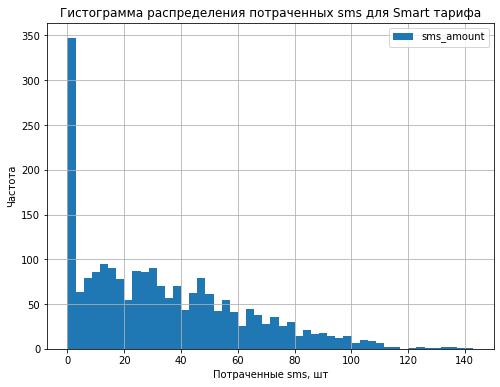

In [70]:
# строим гистрограмму

df_smart.plot(y = 'sms_amount', kind = 'hist', bins = 50, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных sms для Smart тарифа")
plt.xlabel("Потраченные sms, шт")
plt.ylabel("Частота")
plt.show()

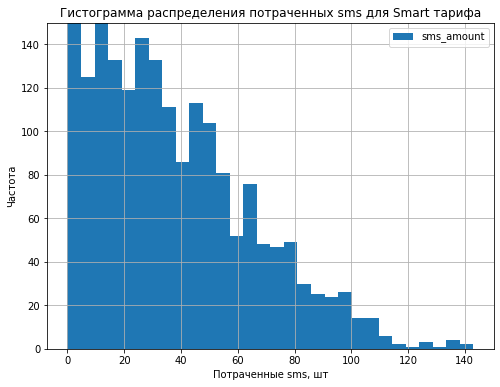

In [71]:
# посмотрим поближе

df_smart.plot(y = 'sms_amount', kind = 'hist', bins = 30, figsize = (8,6), grid=True, rot=0)
plt.ylim(0, 150)
plt.title("Гистограмма распределения потраченных sms для Smart тарифа")
plt.xlabel("Потраченные sms, шт")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.6</b></font>
 
Распределение похоже на распределение Пуасонна, если бы не большое количество нулывых значений. Медиана - 28 шт, лимит тарифа - 50 шт. Видим, что много людей не пользуются смс, но есть и те, кому 50 шт мало. 

In [72]:
# посмотрим на статистику по spent_gb

df_smart['spent_gb'].describe()

count    2118.000000
mean       16.390463
std         5.714185
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: spent_gb, dtype: float64

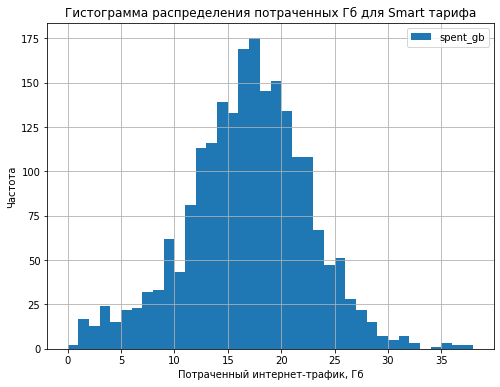

In [73]:
# строим гистрограмму

df_smart.plot(y = 'spent_gb', kind = 'hist', bins = 38, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных Гб для Smart тарифа")
plt.xlabel("Потраченный интернет-трафик, Гб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.7</b></font>
 
Распределение похоже на нормальное. Медиана (== пик) - 17 Гб, лимит тарифа - 15 Гб. А значит, больше, чем 50% переплачивают за интернет.

In [74]:
# посмотрим на статистику по profit

df_smart['profit'].describe()

count    2118.000000
mean     1299.489613
std       821.963102
min       550.000000
25%       568.000000
50%      1046.500000
75%      1750.000000
max      6770.000000
Name: profit, dtype: float64

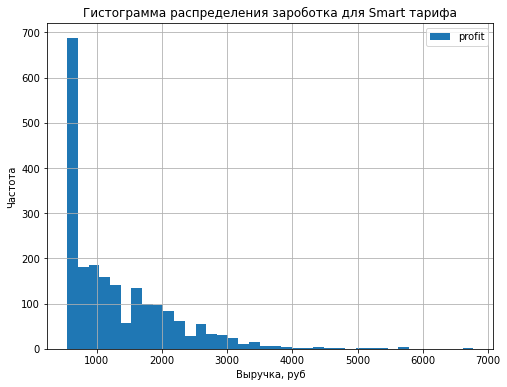

In [75]:
# строим гистрограмму

df_smart.plot(y = 'profit', kind = 'hist', bins = 38, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения зароботка для Smart тарифа")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

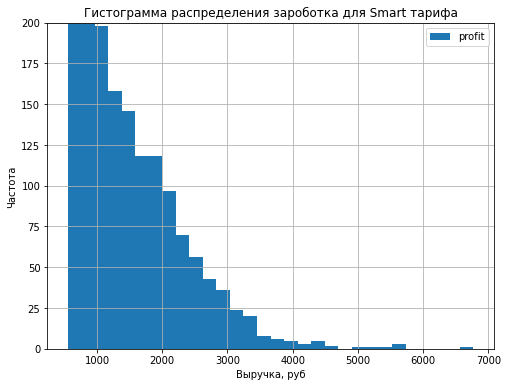

In [76]:
# посмотрим поближе

df_smart.plot(y = 'profit', kind = 'hist', bins = 30, figsize = (8,6), grid=True, rot=0)
plt.ylim(0, 200)
plt.title("Гистограмма распределения зароботка для Smart тарифа")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.8</b></font>
 
Распределение похоже на распределение Пуассона (исключая значение 550). Медиана - 1053 шт, плата за тариф - 550 р. А значит, что 50% пользователей точно переплачивают почти в два раза. Есть и те, кто платит в 5 раз больше!

### Гистрограммы Ultra тарифа

In [77]:
# посмотрим на статистику по spent_min

df_ultra['spent_min'].describe()

count     909.000000
mean      531.930693
std       320.472257
min         0.000000
25%       286.000000
50%       523.000000
75%       753.000000
max      1673.000000
Name: spent_min, dtype: float64

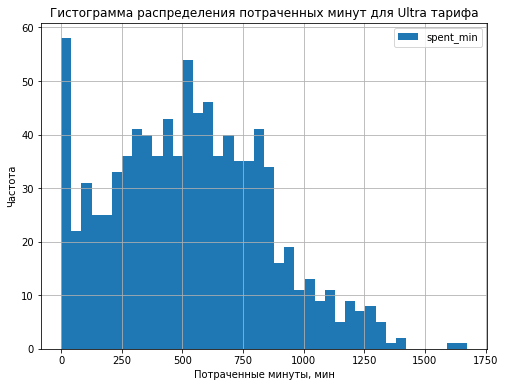

In [78]:
# строим гистрограмму

df_ultra.plot(y = 'spent_min', kind = 'hist', bins = 40, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных минут для Ultra тарифа")
plt.xlabel("Потраченные минуты, мин")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.9</b></font>
 
Распределение похоже на нормальное (исключая нулевые значения). Медиана (== пик) - 523 мин, лимит тарифа - 3000 мин. Выходит, много пользователей не пользуются звонками (например использую интернет-звонки) или у таких людей много пропущенных. А так видим, что пользователи не превышают лимита.

In [79]:
# посмотрим на статистику по sms_amount

df_ultra['sms_amount'].describe()

count    909.000000
mean      51.218922
std       48.344162
min        0.000000
25%        9.000000
50%       40.000000
75%       80.000000
max      224.000000
Name: sms_amount, dtype: float64

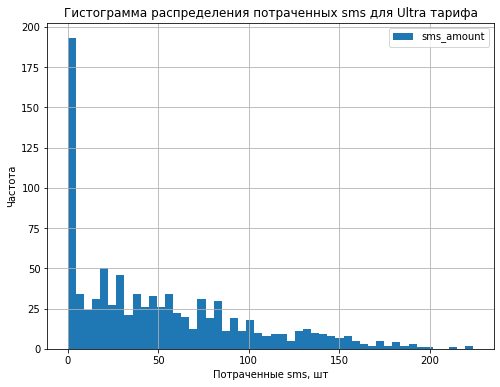

In [80]:
# строим гистрограмму

df_ultra.plot(y = 'sms_amount', kind = 'hist', bins = 50, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных sms для Ultra тарифа")
plt.xlabel("Потраченные sms, шт")
plt.ylabel("Частота")
plt.show()

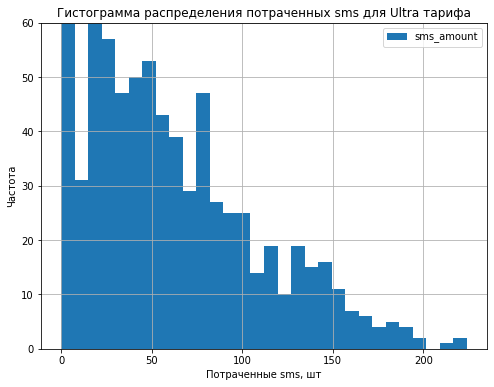

In [81]:
# посмотрим поближе

df_ultra.plot(y = 'sms_amount', kind = 'hist', bins = 30, figsize = (8,6), grid=True, rot=0)
plt.ylim(0, 60)
plt.title("Гистограмма распределения потраченных sms для Ultra тарифа")
plt.xlabel("Потраченные sms, шт")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.10</b></font>
 
Распределение похоже на распределение Пуасонна, если бы не большое количество нулывых значений. Медиана - 40 шт, лимит тарифа - 1000 шт. Видим, что много людей не пользуются смс (как и в smart) и до превышения лимита еще много неиспользованных смс.

In [82]:
# посмотрим на статистику по spent_gb

df_ultra['spent_gb'].describe()

count    909.000000
mean      19.610561
std        9.748723
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: spent_gb, dtype: float64

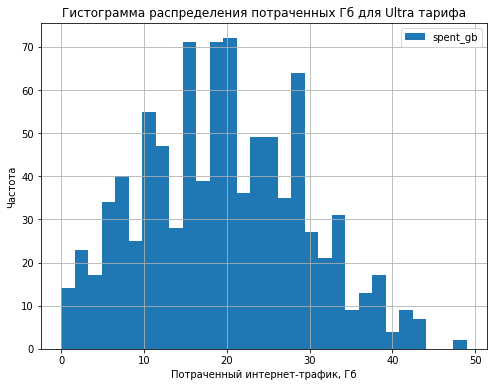

In [83]:
# строим гистрограмму

df_ultra.plot(y = 'spent_gb', kind = 'hist', bins = 30, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения потраченных Гб для Ultra тарифа")
plt.xlabel("Потраченный интернет-трафик, Гб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.11</b></font>
 
Распределение похоже на нормальное. Медиана (== пик) - 19 Гб, лимит тарифа - 30 Гб. Видим, что большинство людей используют меньше 40 Гб, а значит немного превышают лимит.

In [84]:
# посмотрим на статистику по profit

df_ultra['profit'].describe()

count     909.000000
mean     2066.996700
std       368.904052
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: profit, dtype: float64

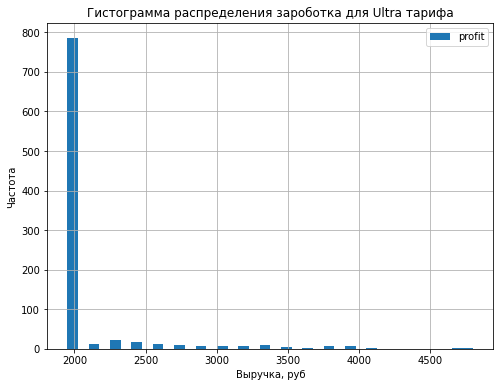

In [85]:
# строим гистрограмму

df_ultra.plot(y = 'profit', kind = 'hist', bins = 38, figsize = (8,6), grid=True, rot=0)
plt.title("Гистограмма распределения зароботка для Ultra тарифа")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

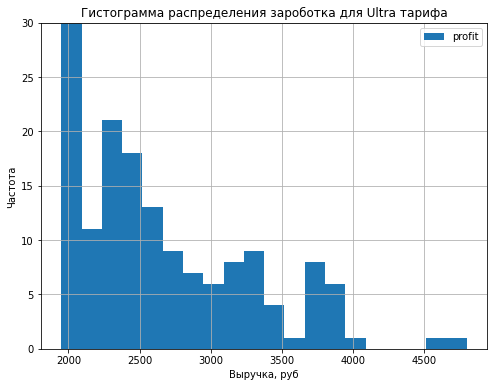

In [86]:
# посмотрим поближе

df_ultra.plot(y = 'profit', kind = 'hist', bins = 20, figsize = (8,6), grid=True, rot=0)
plt.ylim(0, 30)
plt.title("Гистограмма распределения зароботка для Ultra тарифа")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 6.12</b></font>
 
Распределение похоже на распределение Пуассона (исключая значение 550). Медиана - 1950 руб, плата за тариф - 1950 р. Подавляющее большиснтво людей платат только абоненстскую плату. А так, есть значения, которые выше в 2 раза.

### Визуализация сравнений

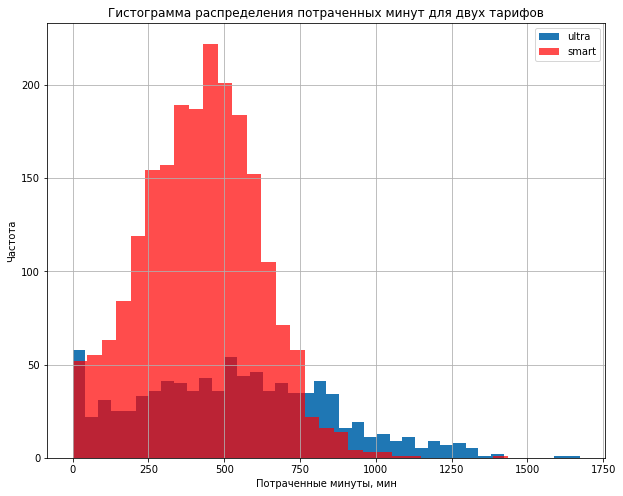

In [87]:
# минуты

ax = df_ultra.plot(y = 'spent_min', kind = 'hist', bins = 40, figsize = (10,8), grid=True, rot=0, label='ultra')
df_smart.plot(y = 'spent_min', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='red', alpha=0.7, label='smart')
plt.title("Гистограмма распределения потраченных минут для двух тарифов")
plt.xlabel("Потраченные минуты, мин")
plt.ylabel("Частота")
plt.show()

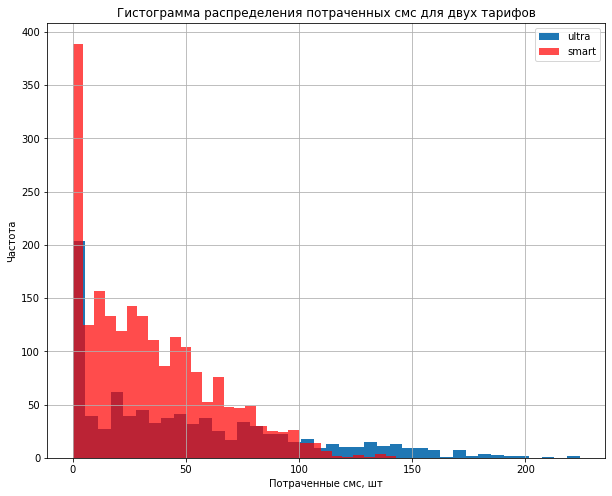

In [88]:
# смс

ax = df_ultra.plot(y = 'sms_amount', kind = 'hist', bins = 40, figsize = (10,8), grid=True, rot=0, label='ultra')
df_smart.plot(y = 'sms_amount', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='red', alpha=0.7, label='smart')
plt.title("Гистограмма распределения потраченных смс для двух тарифов")
plt.xlabel("Потраченные смс, шт")
plt.ylabel("Частота")
plt.show()

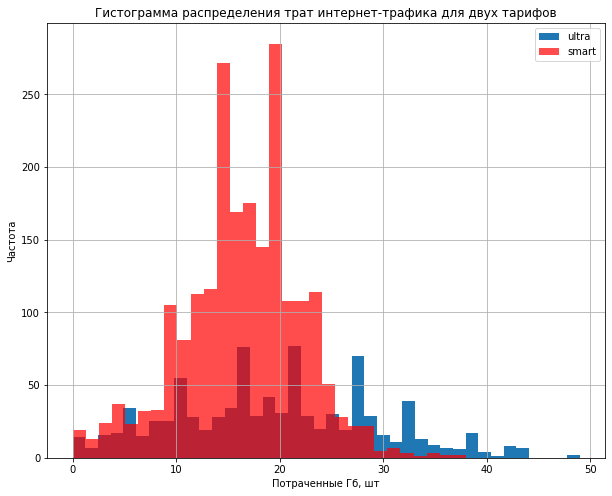

In [89]:
# Гб

ax = df_ultra.plot(y = 'spent_gb', kind = 'hist', bins = 40, figsize = (10,8), grid=True, rot=0, label='ultra')
df_smart.plot(y = 'spent_gb', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='red', alpha=0.7, label='smart')
plt.title("Гистограмма распределения трат интернет-трафика для двух тарифов")
plt.xlabel("Потраченные Гб, шт")
plt.ylabel("Частота")
plt.show()

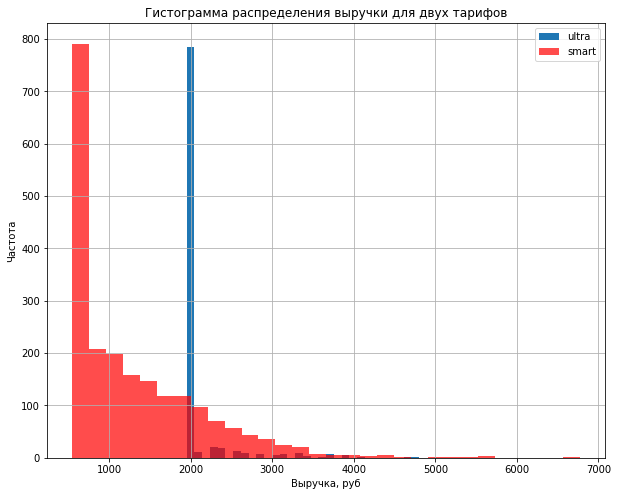

In [90]:
# выручка

ax = df_ultra.plot(y = 'profit', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, label='ultra')
df_smart.plot(y = 'profit', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='red', alpha=0.7, label='smart')
plt.title("Гистограмма распределения выручки для двух тарифов")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

### Вывод

- С тарифом Смарт люди чаще разговаривают по телефону, хотя медиана больше тарифа Ультра.  
- По двум тарифам ситуация похожая - большинство не пользуется смс. Но в тарифе Смарт люди отправляют смс чаще.  
- Большая часть людей с тарифом Смарт превышает лимит. Для Ультра в этом плане нет причин для беспокойств.  
- Выручки явно больше со Смарт тарифа.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Проверка гипотез

I. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;  
II. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  
Пороговое значение alpha задайте самостоятельно.

Поясните:  
как вы формулировали нулевую и альтернативную гипотезы;  
какой критерий использовали для проверки гипотез и почему.

### I гипотеза

Нулева гипотеза по правилам формируется со знаком равентсва. Тогда:  

* H_0 (нулевая гипотеза) - Средняя выручка пользователей тарифа Ультра равна средней выручки пользователей тарифа Смарт  
* H1 (альтернативная гипотеза) - Средняя выручка пользователей тарифа Ультра не равна средней выручки пользователей тарифа Смарт

Критический уровень статистической значимости (p_value) будет 0.05.  

1) проверим, что распределение нормальное (Гауссовское) - scipy.stats.normaltest  
2) проверим гипотезу (гауссовское распределение - scipy.stats.ttest_ind (независимые выборки), не гауссовское -  scipy.stats.ks_2samp)

In [91]:
# создаем выборку

smart = df_smart['profit']
ultra = df_ultra['profit']

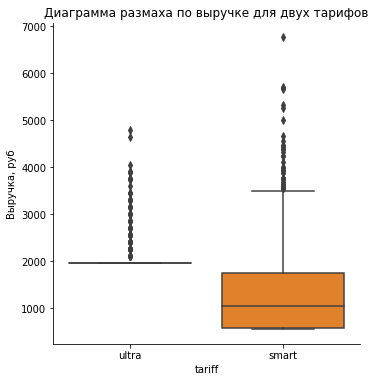

In [92]:
# cначала построим диаграммы размаха для анализа выбросов

sns.catplot(x='tariff', y="profit", kind="box", data=df)
plt.ylabel('Выручка, руб')
plt.title("Диаграмма размаха по выручке для двух тарифов")
plt.show()

<font color='orange'><b>🙊 Наблюдение 7.0</b></font>
 
Уже видно, что данные не похожи.

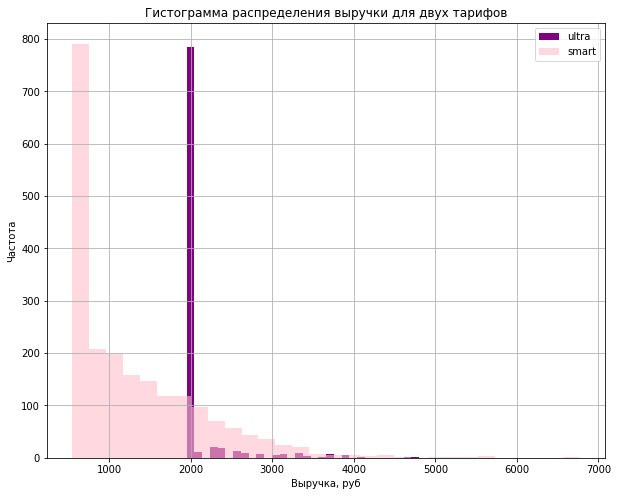

In [93]:
# еще раз выведем гистрогамму выручки

ax = ultra.plot(kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, label='ultra', color='purple')
smart.plot(kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='pink', alpha=0.6, label='smart')
ax.legend()
plt.title("Гистограмма распределения выручки для двух тарифов")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 7.1</b></font>
 
Распределения явно не нормальные.

In [94]:
# проверка распределения выборки Ultra на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(ultra.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

736.5850371898209 1.1287335862745549e-160
Отвергаем нулевую гипотезу


In [95]:
# проверка распределения выборки Smart на нормальность
# H_0 - распределение нормальное

value, p = normaltest(smart.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

592.1983521800387 2.5454333389429007e-129
Отвергаем нулевую гипотезу


<font color='orange'><b>🙊 Наблюдение 7.2</b></font>
 
Так как вероятность того, что выборки имеют не нормальное распределение больше 95%, сначала испольлуем p_value с помощью теста Колмогорова-Смирнова, а потом просчитаем p_value с пломощью t-теста Уэлча (модифицированный t-критерий Стьюдента)

In [96]:
# тест Колмогорова-Смирнова

print(f'cреднее smart: {round(pd.Series(smart).mean(), 2)}')
print(f'cреднее ultra: {round(pd.Series(ultra).mean(), 2)}')
alpha = .05

results = ks_2samp(smart, ultra)

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее smart: 1299.49
cреднее ultra: 2067.0
p_value: 7.56e-322
Отвергаем нулевую гипотезу


In [97]:
# t-тест Уэлча

smart = df_smart['profit']
ultra = df_ultra['profit']

print(f'cреднее smart: {round(pd.Series(smart).mean(), 2)}')
print(f'cреднее ultra: {round(pd.Series(ultra).mean(), 2)}')
alpha = .05

results = st.ttest_ind(smart, ultra, equal_var = False) # False, так как дисперсии отличаются (пункт 6.5)

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее smart: 1299.49
cреднее ultra: 2067.0
p_value: 1.7899147970322058e-230
Отвергаем нулевую гипотезу


### Вывод по I гипотезе

Можно сказать, что выручка по двум тарифам сильно различается, что было видно и до этого. Так же видим, что cредняя выручка тарифа Ultra выше.

### II гипотеза

* H_0 (нулевая гипотеза) - Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов 
* H1 (альтернативная гипотеза) - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов 

Критический уровень статистической значимости (p_value) будет 0.05.  

1) проверим, что распределение нормальное (Гауссовское) - scipy.stats.normaltest  
2) проверим гипотезу (гауссовское распределение - scipy.stats.ttest_ind (независимые выборки), не гауссовское -  scipy.stats.ks_2samp)

In [98]:
# создадм две таблицы: москва и остальные 

moscow_df = df[df['city'] == 'Москва']
other_df = df[df['city'] != 'Москва']

# создадм выборки

moscow = moscow_df['profit']
other = other_df['profit']

In [99]:
# проверим как распределились тарифы по городам

tarif_mosc = moscow_df.pivot_table(index = 'tariff', values = 'profit', aggfunc = 'count')
tarif_other = other_df.pivot_table(index = 'tariff', values = 'profit', aggfunc = 'count')

print(f"ultra/smart moscow {round(tarif_mosc['profit'][1]/tarif_mosc['profit'][0], 2)}")
print(f"ultra/smart other {round(tarif_other['profit'][1]/tarif_other['profit'][0], 2)}")

ultra/smart moscow 0.58
ultra/smart other 0.4


<font color='orange'><b>🙊 Наблюдение 7.3</b></font>
 
Видно, что в выборке other smart тарифов больше.

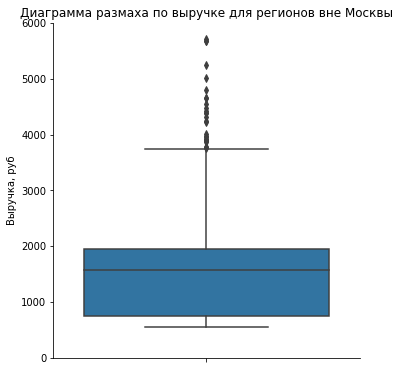

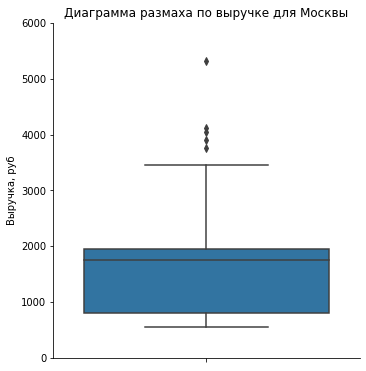

In [100]:
# cначала построим диаграммы размаха для анализа выбросов

sns.catplot(y="profit", kind="box", data=other_df)
plt.ylim(0, 6000)
plt.ylabel('Выручка, руб')
plt.title("Диаграмма размаха по выручке для регионов вне Москвы")

sns.catplot(y="profit", kind="box", data=moscow_df, ax=ax)
plt.ylim(0, 6000)
plt.ylabel('Выручка, руб')
plt.title("Диаграмма размаха по выручке для Москвы")
plt.show()

<font color='orange'><b>🙊 Наблюдение 7.4</b></font>
 
Выборки похожи.

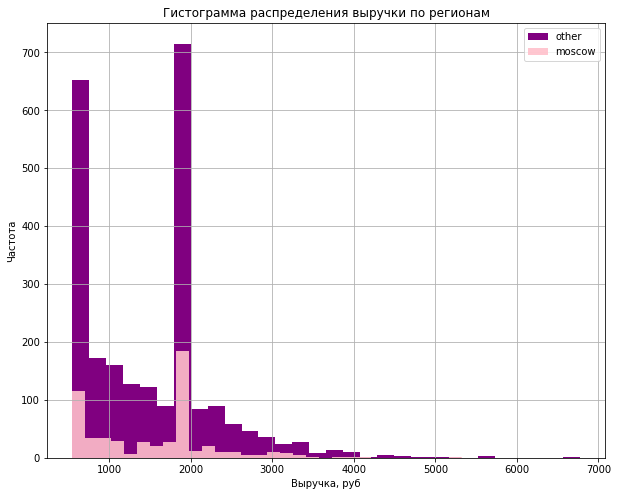

In [101]:
# выведем гистрогамму выручки 
# не работает label

ax = other_df.plot(y = 'profit', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, label='other', color="purple")
moscow_df.plot(y = 'profit', kind = 'hist', bins = 30, figsize = (10,8), grid=True, rot=0, ax=ax, color='pink', alpha=0.9, label='moscow')
ax.legend()
plt.title("Гистограмма распределения выручки по регионам")
plt.xlabel("Выручка, руб")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>🙊 Наблюдение 7.4</b></font>
 
Выборки так же не похожи на нормальные. Сделаем все, как в прошлый раз

In [102]:
# проверка распределения выборки Moscow на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(moscow.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

29.756245461685076 3.4555198884171684e-07
Отвергаем нулевую гипотезу


In [103]:
# проверка распределения выборки other на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(other.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

331.604588555135 9.839624118526642e-73
Отвергаем нулевую гипотезу


In [104]:
# тест Колмогорова-Смирнова

print(f'cреднее по Москве: {round(pd.Series(moscow).mean(), 2)}')
print(f'cреднее по остальным регионам: {round(pd.Series(other).mean(), 2)}')
alpha = .05

results = ks_2samp(moscow, other)

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее по Москве: 1545.01
cреднее по остальным регионам: 1526.48
p_value: 0.321160703812668
Не получилось отвергнуть нулевую гипотезу


In [105]:
# t-тест Уэлча

moscow = moscow_df['profit']
other = other_df['profit']

print(f'cреднее по Москве: {round(pd.Series(moscow).mean(), 2)}')
print(f'cреднее по остальным регионам: {round(pd.Series(other).mean(), 2)}')
alpha = .05

results = st.ttest_ind(moscow, other, equal_var = False) # False, так как дисперсии скорее всего отличаются

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее по Москве: 1545.01
cреднее по остальным регионам: 1526.48
p_value: 0.6003664030656649
Не получилось отвергнуть нулевую гипотезу


### Вывод по II гипотезе

Полученное нами p-value больше 0.05, а значит есть вероятность, что средняя выручка по Москве близка к средней вырочки по остальным регионам и мы не можем отвергнуть нулевую гипотезу.   
Значит, альтернативную гипотезу о различии средних мы отвергаем.  
Среднии и правда не сильно отличаются, что видно и по диаграммам выбросов.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Промежуточный итог

### Оценка использования пакетов

In [106]:
# подведем итог использования тарифов по среднему значению

smart_mean_call = (df[(df['tariff'] == 'smart')]['spent_min']/500).mean()
print('Процент использования пакета минут в тарифе "Smart": {:.0%} ({:,.0f} мин)'.
      format(smart_mean_call, smart_mean_call * 500))

smart_mean_sms = (df[(df['tariff'] == 'smart')]['sms_amount']/50).mean()
print('Процент использования пакета смс в тарифе "Smart": {:.0%} ({:.0f} шт)'.
      format(smart_mean_sms, smart_mean_sms * 50))

smart_mean_gb = (df[(df['tariff'] == 'smart')]['spent_gb']/15).mean()
print('Процент использования интернет-пакета в тарифе "Smart": {:.0%} ({:.0f} Гб)'.
      format(smart_mean_gb, smart_mean_gb * 15))
print('***********************************************************************')

ultra_mean_call = (df[(df['tariff'] == 'ultra')]['spent_min']/3000).mean()
print('Процент использования пакета минут в тарифе "Ultra": {:.0%} ({:,.0f} мин)'.
      format(ultra_mean_call, ultra_mean_call * 3000))

ultra_mean_sms = (df[(df['tariff'] == 'ultra')]['sms_amount']/1000).mean()
print('Процент использования пакета смс в тарифе "Ultra": {:.0%} ({:.0f} шт)'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

ultra_mean_gb = (df[(df['tariff'] == 'ultra')]['spent_gb']/30).mean()
print('Процент использования интернет-пакета в тарифе "Ultra": {:.0%} ({:.0f} Гб)'.
      format(ultra_mean_gb, ultra_mean_gb * 30))

Процент использования пакета минут в тарифе "Smart": 85% (423 мин)
Процент использования пакета смс в тарифе "Smart": 67% (34 шт)
Процент использования интернет-пакета в тарифе "Smart": 109% (16 Гб)
***********************************************************************
Процент использования пакета минут в тарифе "Ultra": 18% (532 мин)
Процент использования пакета смс в тарифе "Ultra": 5% (51 шт)
Процент использования интернет-пакета в тарифе "Ultra": 65% (20 Гб)


#### Вывод
 
Как видим, пользователи Smart выжимают из звонков и интернет-трафика максимум и даже больше. А вот абоненты Ultra тарифа не используют все возможности по полной (два пакета услуг используются меньше чем на 20% от своего потенциала).

### Оценка использования пакетов сверх лимита

In [107]:
# посмотрим на сколько в среднем в каждом тарифе не хватает пакетов услуг

smart_over_call = (df[(df['tariff'] == 'smart')]['min_over']).mean()
smart_over_call_rub = smart_over_call * 3
print('Превышение пакета минут в тарифе "Smart": {:.0f} мин ({:,.0f} руб)'.
      format(smart_over_call, smart_over_call_rub))

smart_over_sms = (df[(df['tariff'] == 'smart')]['sms_over']).mean()
smart_over_sms_rub = smart_over_sms * 3
print('Превышение пакета смс в тарифе "Smart": {:.0f} шт ({:,.0f} руб)'.
      format(smart_over_sms, smart_over_sms_rub))

smart_over_gb = (df[(df['tariff'] == 'smart')]['gb_over']).mean()
smart_over_gb_rub = smart_over_gb * 200
print('Превышение пакета интернет-трафика в тарифе "Smart": {:.0f} Гб ({:,.0f} руб)'.
      format(smart_over_gb, smart_over_gb_rub))

print('***********************************************************************')

ultra_over_call = (df[(df['tariff'] == 'ultra')]['min_over']).mean()
ultra_over_call_rub = ultra_over_call * 1
print('Превышение пакета минут в тарифе "Ultra": {:.0f} мин ({:,.0f} руб)'.
      format(ultra_over_call, ultra_over_call_rub))

ultra_over_sms = (df[(df['tariff'] == 'ultra')]['sms_over']).mean()
ultra_over_sms_rub = ultra_over_sms * 1
print('Превышение пакета смс в тарифе "Ultra": {:.0f} шт ({:,.0f} руб)'.
      format(ultra_over_sms, ultra_over_sms_rub))

ultra_over_gb = (df[(df['tariff'] == 'ultra')]['gb_over']).mean()
ultra_over_gb_rub = ultra_over_gb * 150
print('Превышение пакета интернет-трафика в тарифе "Ultra": {:.0f} Гб ({:,.0f} руб)'.
      format(ultra_over_gb, ultra_over_gb_rub))

Превышение пакета минут в тарифе "Smart": 43 мин (130 руб)
Превышение пакета смс в тарифе "Smart": 6 шт (18 руб)
Превышение пакета интернет-трафика в тарифе "Smart": 3 Гб (602 руб)
***********************************************************************
Превышение пакета минут в тарифе "Ultra": 0 мин (0 руб)
Превышение пакета смс в тарифе "Ultra": 0 шт (0 руб)
Превышение пакета интернет-трафика в тарифе "Ultra": 1 Гб (117 руб)


#### Вывод
 
Эти данные потверждают вывод выше: пользователи тарифа Smart переплачивают по всем пакетам, Ultra - только интернет, и то не особо много в среднем.

### Общая выручка по двум тарифам

In [108]:
# группируем данные по выручке

total_profit = df.groupby(['tariff'])['user_id'].agg(["sum", "count"])
total_profit = total_profit.reset_index()
total_profit

,tariff,sum,count
0,smart,2643921,2118
1,ultra,1150630,909


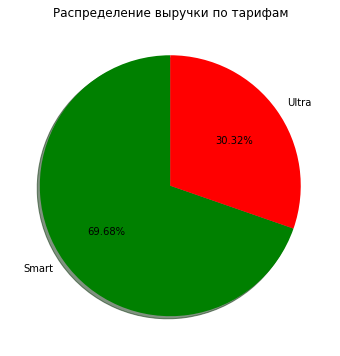

In [109]:
# группируем данные по выручке

total_profit_sum = total_profit['sum']

# строим круговую диаграмму

tariff_name = ["Smart", "Ultra"]
fig = plt.figure(figsize =(6, 6))
plt.pie(total_profit_sum, labels=tariff_name, autopct='%1.2f%%', shadow=True, startangle=90, colors="green")
plt.title("Распределение выручки по тарифам")
plt.show()

#### Вывод

Как и писали раньше, видим, что пользователи тарифа Smart приносят больше выручки за счет количества пользователей (~72%) и использования тарифа сверхлимитов.  
Выручку в 30% от общей суммы формируют всего 28% пользователей - пользователи тарифа Ultra.

<b>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Общий вывод

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

- Люди чаще покупают Smart тариф   
- Интернет - самый прибыльный пакет и которого нужно больше для двух тарифов  
- Прибыль больше дает Smart тариф за счет покупки доп услуг  
- Ultra тариф для пользователей избыточный (кроме интернет-трафика)  
- Smart тариф - недостаточный по всем пакетам услуг  
- Средняя выручка у тарифа Ultra выше, так как цены за тариф тоже выше  
- Смс в обоих тарифах не очень востребованы  
- Разница между выручкой регионов и Москвы незначительная

Мы изучили данные пользователей двух тарифов: дешевый Smart, где люди часто переплачивают за всех пакеты услуг и есть дорогой тариф - Ultra, где лимитов пакетов услуг большей части пользователей всегда хватает (иногда превышают лимит интернета на 1 Гб).   

Я вижу, что оба тарифа не оптимальны. Средняя плата за Smart тариф с переплатами выходит ~ 550 + 130 + 20 + 600 = 1300 р. (что потверждается в п.6.6). Значит в теории, пользователи Smart  в среднем готовы платить такую цену за удобный пакет услуг.   
В новый тариф надо включить след пакеты - 700 мин, 100 смс, 20 Гб. Так как пользователи Smart в среднем и так платят в два раза больше тарифа, думаю компания много не потеряет, а людям станет удобнее.